Based off the lucid tensorflow 2d Neural style transfer example found here: https://github.com/tensorflow/lucid

The original example provided there no longer works, but I found a solution so I am reuploading it. All credits to lucid team. 

any questions? my email: josepherickson135@gmail.com
facebook: https://www.facebook.com/profile.php?id=100015734717430
my base github repo: https://github.com/400lbhacker



In [1]:
# Imports
!pip install lucid>=0.2.3
%tensorflow_version 1.x
import numpy as np
import tensorflow as tf                                            
from lucid.modelzoo import vision_models
from lucid.misc.io import show, load, save
from lucid.misc.tfutil import create_session
import lucid.optvis.objectives as objectives
import lucid.optvis.param as param
import lucid.optvis.render as render
from lucid.optvis.objectives import wrap_objective
tf.test.is_gpu_available()

model = vision_models.InceptionV1()
model.load_graphdef()
model.layers
print("finished.. continue to next code box")


TensorFlow 1.x selected.


W1019 17:54:51.060240 139953650743168 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/lucid/misc/io/writing.py:62: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.

W1019 17:54:51.065006 139953650743168 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/lucid/misc/io/writing.py:70: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W1019 17:54:52.192210 139953650743168 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/lucid/misc/io/loading.py:72: The name tf.GraphDef is deprecated. Please use tf.compat.v1.GraphDef instead.



finished.. continue to next code box


((600, 600, 3), (600, 600, 3))



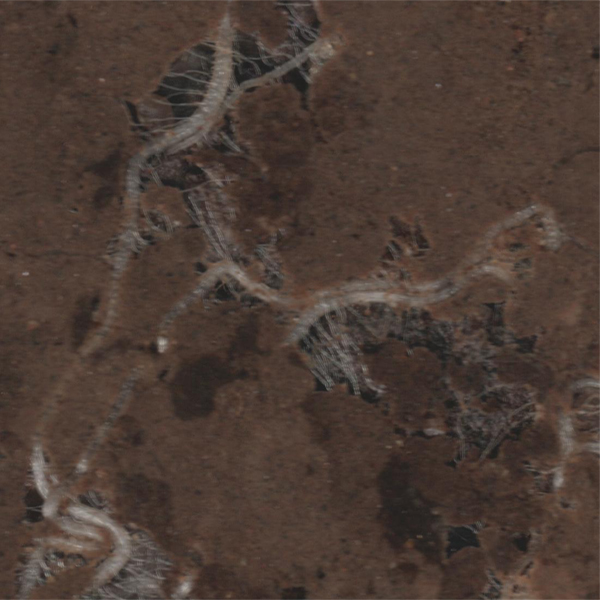


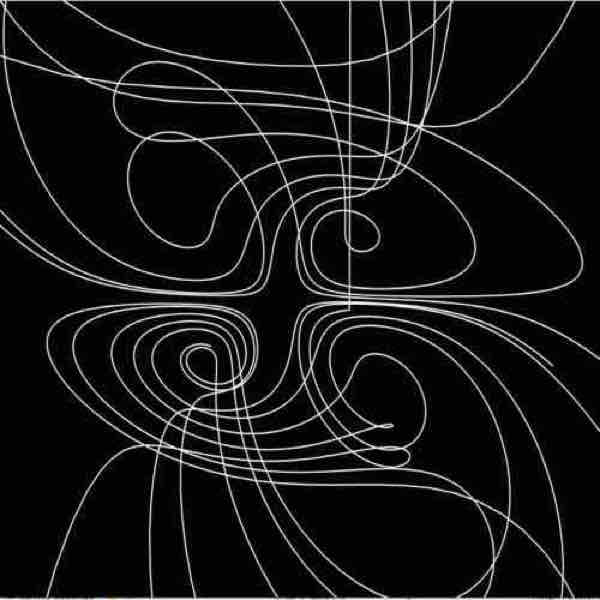

finished.. continue to next code box


In [2]:
from google.colab import files


content_image = load("/content/sample_data/root8.jpg")[..., :3]
style_image = load("/content/sample_data/Black_MAIN_600.jpg")[..., :3] 
print(content_image.shape, style_image.shape)

show(content_image)
show(style_image)
print("finished.. continue to next code box")


W1019 17:56:40.789407 139953650743168 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/lucid/optvis/param/spatial.py:54: The name tf.spectral.irfft2d is deprecated. Please use tf.signal.irfft2d instead.

W1019 17:56:40.841949 139953650743168 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/lucid/optvis/render.py:88: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W1019 17:56:41.086031 139953650743168 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/lucid/optvis/render.py:223: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1019 17:56:41.088424 139953650743168 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/lucid/optvis/render.py:241: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.

W1019 17:56:41.091028 139953650743168 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/


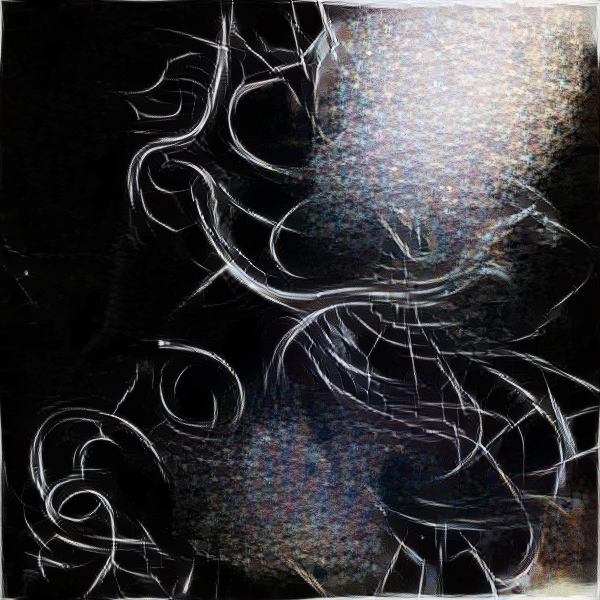
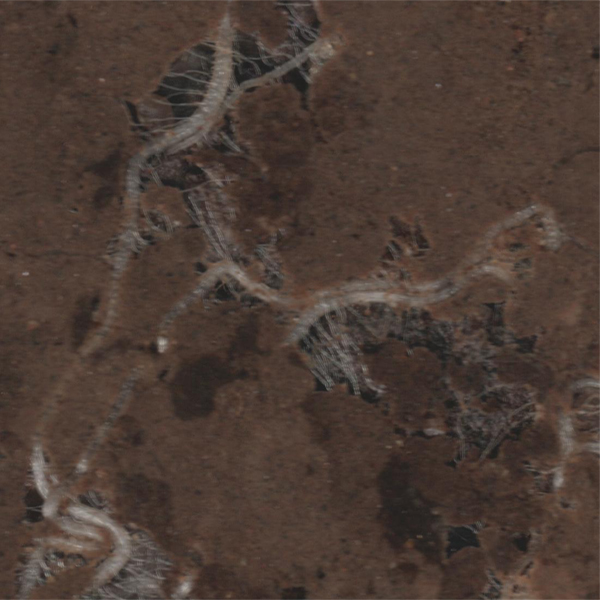
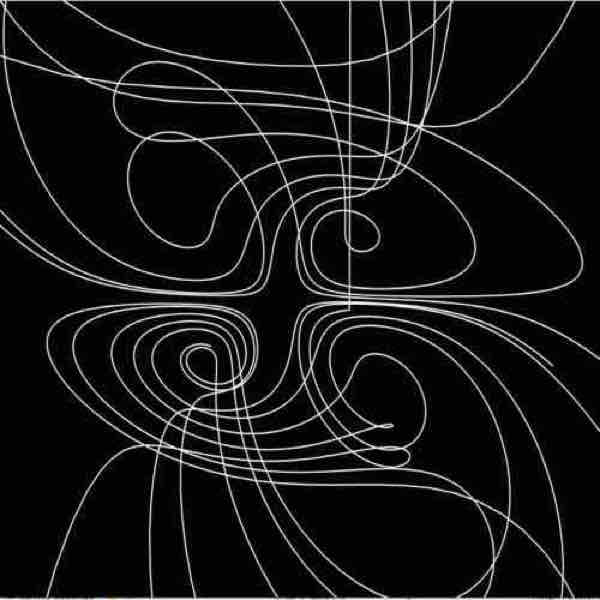

In [3]:
style_layers = [
  'conv2d2',
  'mixed3a',
  'mixed4a',
  'mixed4b',
  'mixed4c',
]

content_layers = [
  'mixed3b',
]

def style_transfer_param(content_image, style_image, decorrelate=True, fft=True):
  style_transfer_input = param.image(*content_image.shape[:2], decorrelate=decorrelate, fft=fft)[0]
  content_input = content_image
  style_input = tf.random_crop(style_image, content_image.shape)
  return tf.stack([style_transfer_input, content_input, style_input])

# these constants help remember which image is at which batch dimension
TRANSFER_INDEX = 0
CONTENT_INDEX = 1
STYLE_INDEX = 2
style_transfer_param(content_image, style_image).shape
def mean_L1(a, b):
  return tf.reduce_mean(tf.abs(a-b))
@wrap_objective
def activation_difference(layer_names, activation_loss_f=mean_L1, transform_f=None, difference_to=CONTENT_INDEX):
  def inner(T):
    # first we collect the (constant) activations of image we're computing the difference to
    image_activations = [T(layer_name)[difference_to] for layer_name in layer_names]
    if transform_f is not None:
      image_activations = [transform_f(act) for act in image_activations]

    # we also set get the activations of the optimized image which will change during optimization
    optimization_activations = [T(layer)[TRANSFER_INDEX] for layer in layer_names]
    if transform_f is not None:
      optimization_activations = [transform_f(act) for act in optimization_activations]

    # we use the supplied loss function to compute the actual losses
    losses = [activation_loss_f(a, b) for a, b in zip(image_activations, optimization_activations)]
    return tf.add_n(losses)

  return inner


def gram_matrix(array, normalize_magnitue=True):
    channels = tf.shape(array)[-1]
  
  
    array_flat = tf.reshape(array, [-1, channels])
    gram_matrix = tf.matmul(array_flat, array_flat, transpose_a=True)
    if normalize_magnitue:
      length = tf.shape(array_flat)[0]
    gram_matrix /= tf.cast(length, tf.float32)
    return gram_matrix



param_f = lambda: style_transfer_param(content_image, style_image)

content_obj = 90 * activation_difference(content_layers, difference_to=CONTENT_INDEX)
content_obj.description = "Content Loss"

style_obj =  activation_difference(style_layers, transform_f=gram_matrix, difference_to=STYLE_INDEX)
style_obj.description = "Style Loss"

objective = - content_obj - style_obj

vis = render.render_vis(model, objective, param_f=param_f, thresholds=[512], verbose=False, print_objectives=[content_obj, style_obj])[-1]
show(vis)